# Cancellation model_v1.X  
Deals with data enrolled after 1/1/2016, pulled 2020/03/13. Class is 1 for cancel, 0 for not cancel. feature is Hardship__c. 
Joins with information about Cases and Twilio Calls, deals, and RI.
By Dequan Er  

03/18/2020


* In this X version, it aims to develop tools and infurstractures for text features.
* should time allow, it will also investigate the LSTM model with sliced time period.

# Summary  
Create ML model to predict cancellation probability, both at Enrollment and ongoing throughout the client’s journey.  
1. feature selection and feature importance
2. model training
3. build infurstracture for further model with LSTM or CNN model.

In [136]:
# Usual imports
import pandas as pd
import numpy as np
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.layers import GlobalMaxPooling1D

import nltk
nltk.download('wordnet')
import re # DE add
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
import string

from nltk.corpus import stopwords
from sklearn.manifold import TSNE

stop=set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dequan.er/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


write basic functions and set up data_pull_date and ytica_start_date.

In [ ]:
# Setup initial variables, define functions

test_date_start = pd.to_datetime('2020-03-01')
test_date_end = pd.to_datetime('2020-03-07')

data_pull_date = pd.to_datetime('2020-03-13')
ytica_start_date = pd.to_datetime('2018-01-01')

# def lemmatize_text(text):
#     '''Conver text into list of lemmatized words'''
#     return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

def date_to_int(date_str, Format):
    '''
    Parse datetime into integer.
    Format = 1: 'yyyy-mm-dd...'
    Format = 2: 'mm/dd/yyyy'
    '''
    if date_str == date_str:
        if Format == 1:
            y = int(date_str[0:4])*10000
            m = int(date_str[5:7])*100
            d = int(date_str[8:10])
        elif Format == 2:
            y = int(date_str[6:10])*10000
            m = int(date_str[0:2])*100
            d = int(date_str[3:5])
        else:
            print('Invalid Format: 1 for "yyyy-mm-dd", 2 for "mm/dd/yyyy"')
            return
        return y+m+d
    else:
        return date_str
    
def plot_feature(df_view, feature, title, x_label, rot=0):
    '''
    Given a dataframe with bucketed feature, 
    plot Class dependence on the given feature
    '''
    df_view = df_view.sort_values(feature, ascending = True)
    plt.subplots(figsize = (15, 8))
    ax = sns.barplot(x = df_view[feature], y = df_view.Class, linewidth=2)
    plt.title(title, fontsize = 25)
    plt.ylabel("% of CCs Legal", fontsize = 15)
    plt.xlabel(x_label,fontsize = 15)
    plt.xticks(rotation = rot);
    #can display feature counts
    #display(df_view[feature].value_counts().sort_index())
    
def labelize(x, scale, limit=1000000000, exception=None, force=100):
    '''
    Bucket a feature into string ranges using floor(x/scale)*scale to determine buckets
    '''
    if force == 100:
        if x < limit:
            return str(int(np.floor(x/scale)*scale)) + "-" + \
                str(int(np.floor(x/scale)*scale + scale))
        else:
            return exception
    else:
        if x < limit:
            a = str(int(np.floor(x/scale)*scale))
            pad = force - len(a)
            a = "0"*pad + a
            b = str(int(np.floor(x/scale)*scale + scale))
            pad = force - len(b)
            b = "0"*pad + b
            return a + "-" + b
        else:
            return exception
        
def timeDiff(col,form,data):
    """
    Input: col of desired date different, date in format col[1]-col[0], arr
    Output: number of years or days
    Form: y for year, d for day, str
    data: the dataFrame to input
    """
    t1 = pd.to_datetime(data[col[0]],errors='coerce')
    t2 = pd.to_datetime(data[col[1]],errors='coerce')
    if form == ('y' or 'Y'):
        return (t2-t1).astype('timedelta64[Y]')
    if form == ('d' or 'D'):
        return (t2-t1).astype('timedelta64[D]')

In [160]:
# import df 
df_deals = pd.read_csv('~/OneDrive - National Debt Relief/1-share_team/cancellation_model_v1.0/data_in/DS_update.csv')#,parse_dates = [2,3,9,13,-2])

df_deals['test_date_start'] = test_date_start
df_deals['test_date_end'] = test_date_end

xx = df_deals[timeDiff(['Final_Cancel_Date__c','test_date_end'],'d',df_deals)>=0]
df_test = xx[timeDiff(['test_date_start','Final_Cancel_Date__c'],'d',xx)>=0]

df_deals['WC_Date'] = df_deals['WC_Complete_Date_Time__c'].astype(str).str[:-18]
df_deals = df_deals.drop(columns='WC_Complete_Date_Time__c')


In [162]:
df = df_deals[:10000]
df_deals.shape, df_test.shape

((562893, 30), (1045, 30))

In [146]:
# df_deals['Class']=False
# df_deals[df_deals.isin(df_test)['Name']]['Class'] = True

Check the data shape. 

In [147]:
df_deals.isnull().values.any(), df_deals.shape

(True, (562893, 30))

In [163]:
df['Class'] = df['Final_Cancel_Date__c'].apply(lambda x: True if x == x else False)

/Users/dequan.er/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [164]:
df = df[['Name','Hardship__c','Class']]#.iloc[:2000]
df = df.dropna()
df['Hardship__c']=df['Hardship__c'].apply(lambda x: str(x))

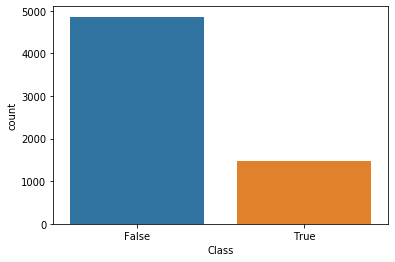

In [165]:
sns.countplot(x='Class', data=df)

In [166]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)


In [167]:
X = []
sentences = list(df['Hardship__c'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [168]:
y = df.Class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Prepare embedding layer

In [169]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 5000

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [170]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('../../Downloads/glove.6B/glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [171]:
embedding_matrix = zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [172]:
def plot_training(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 5000, 50)          452150    
_________________________________________________________________
flatten_5 (Flatten)          (None, 250000)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 250001    
Total params: 702,151
Trainable params: 250,001
Non-trainable params: 452,150
_________________________________________________________________
None
Train on 4046 samples, validate on 1012 samples
Epoch 1/20
4046/4046 [==============================] - 1s 351us/step - loss: 0.5704 - acc: 0.7531 - val_loss: 0.5554 - val_acc: 0.7648
Epoch 2/20
4046/4046 [==============================] - 1s 366us/step - loss: 0.4649 - acc: 0.7810 - val_loss: 0.5393 - val_acc: 0.7727
Epoch 3/20
4046/4046 [========================

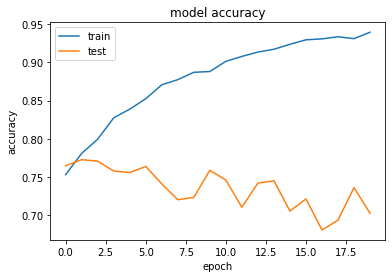

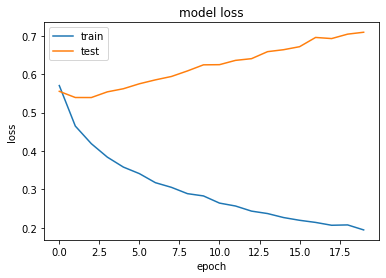

In [173]:
# Simple baseline model
model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

history = model.fit(X_train, y_train, batch_size=64, epochs=20, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
plot_training(history)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 5000, 50)          452150    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 4996, 128)         32128     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 484,407
Trainable params: 32,257
Non-trainable params: 452,150
_________________________________________________________________
None
Train on 4046 samples, validate on 1012 samples
Epoch 1/20
4046/4046 [==============================] - 21s 5ms/step - loss: 0.5459 - acc: 0.7642 - val_loss: 0.5242 - val_acc: 0.7757
Epoch 2/20
4046/4046 [==============================

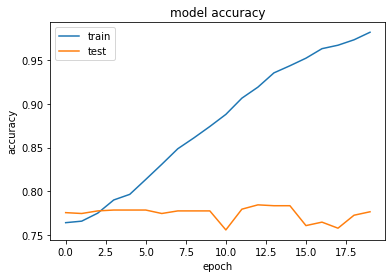

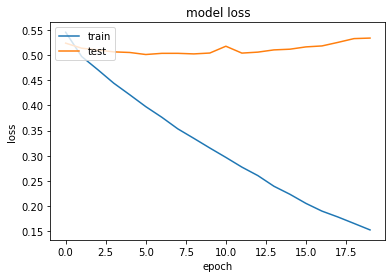

In [175]:
# CNN model
"""
    The use of this model has been tested. Over the 240 k samples with maxLen= 5000, a single epoch takes about 20 mins.
    
"""
model = Sequential()

embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
plot_training(history)

In [194]:
# LSTM 

"""
    LSTM model is more complex in parameters, where LSTM unit is in a chain of making predictions. 
    It has bidirectional understanding of the sentence. 
    
    It seems the LSTM in this version is underfitting. Let me use a deep network to try.
"""
model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(LSTM(128))
# test 
# model.add(LSTM(128,return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(128,return_sequences=True))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
plot_training(history)


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 5000, 50)          452150    
_________________________________________________________________
lstm_25 (LSTM)               (None, 128)               91648     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 129       
Total params: 543,927
Trainable params: 91,777
Non-trainable params: 452,150
_________________________________________________________________
None
Train on 4046 samples, validate on 1012 samples
Epoch 1/6
4046/4046 [==============================] - 173s 43ms/step - loss: 0.6060 - acc: 0.7650 - val_loss: 0.5354 - val_acc: 0.7757
Epoch 2/6
4046/4046 [==============================] - 169s 42ms/step - loss: 0.5467 - acc: 0.7650 - val_loss: 0.5329 - val_acc: 0.7757
Epoch 3/6
4046/4046 [==========================

KeyboardInterrupt: 

In [178]:
X_train

'/Users/dequan.er/Desktop/2-test'